<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/Final_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mapping folder**

# P_value based correlation

In [ ]:
!pip install rasterio
!pip install tqdm
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import rasterio
import glob
import os
import re
from scipy.stats import pearsonr
from tqdm import tqdm
import sys # Import sys to help with error reporting

def extract_year_season(filename):
    """Extract year and season code from filename (e.g., SWATI_2001_02.tif)."""
    match = re.search(r'(\d{4})_(\d{2})', os.path.basename(filename), re.IGNORECASE)
    if match:
        return int(match.group(1)), match.group(2)
    return None, None

def read_season_stack(variable, folder_path, season_code):
    """
    Read and stack files for the specified variable and season code.
    (Error handling and file reading logic as provided by the user)
    """
    pattern = os.path.join(folder_path, f"{variable}_*_*.tif")
    file_list = [f for f in glob.glob(pattern) if f.lower().endswith(f"_{season_code.lower()}.tif")]

    if not file_list:
        raise FileNotFoundError(f"Error: No files found for variable '{variable}' with season code '{season_code}' in folder '{folder_path}'. Check folder path and file naming conventions.")

    try:
        file_year_pairs = [(f, extract_year_season(f)[0]) for f in file_list]
        valid_file_year_pairs = [(f, year) for f, year in file_year_pairs if year is not None]

        if not valid_file_year_pairs:
            raise ValueError(f"Error: No files with valid years found for variable '{variable}' after filtering by season code '{season_code}'.")

        sorted_file_year_pairs = sorted(valid_file_year_pairs, key=lambda item: item[1])
        sorted_file_list = [item[0] for item in sorted_file_year_pairs]
        years = [item[1] for item in sorted_file_year_pairs]

        if len(years) != len(file_list):
            print(f"Warning: {len(file_list) - len(years)} files for variable '{variable}' with season '{season_code}' did not have a valid year in their filename and were excluded.", file=sys.stderr)

    except TypeError as e:
        raise ValueError(f"Error sorting files for variable '{variable}' with season '{season_code}'. Ensure filenames contain year_season pattern (e.g., SWATI_2001_01.tif). Details: {e}")

    try:
        with rasterio.open(sorted_file_list[0]) as src:
            meta = src.meta.copy()
            nodata_value = src.nodata
            first = src.read(1)
            rows, cols = first.shape
            stack = [first]
    except rasterio.errors.RasterioIOError as e:
        raise IOError(f"Error reading the first file '{sorted_file_list[0]}' for variable '{variable}' with season '{season_code}'. Check file integrity and permissions. Details: {e}")

    for file in tqdm(sorted_file_list[1:], desc=f"Reading {variable} files for season {season_code}"):
        try:
            with rasterio.open(file) as src:
                band = src.read(1)
                if band.shape != (rows, cols):
                    raise ValueError(f"Dimension mismatch in file: {file} for variable '{variable}' with season '{season_code}'. Expected shape ({rows}, {cols}), got {band.shape}.")
                stack.append(band)
        except rasterio.errors.RasterioIOError as e:
            print(f"Warning: Could not read file '{file}' for variable '{variable}' with season '{season_code}'. Skipping this file. Details: {e}", file=sys.stderr)
            continue

    if not stack:
        raise ValueError(f"Error: No valid raster bands were successfully read into the stack for variable '{variable}' with season '{season_code}'.")

    return np.stack(stack, axis=0), meta, nodata_value, years, sorted_file_list


def compute_pixelwise_correlation(stack1, stack2, nodata_value):
    """
    Pixelwise Pearson correlation and p-value between two stacks.

    Args:
        stack1 (np.ndarray): The first data stack (time, rows, cols).
        stack2 (np.ndarray): The second data stack (time, rows, cols).
        nodata_value (float or int): The nodata value to ignore.

    Returns:
        tuple: (corr_map, pval_map)
            corr_map (np.ndarray): Map of pixelwise correlation coefficients.
            pval_map (np.ndarray): Map of pixelwise p-values.
    """
    if stack1.shape != stack2.shape:
        raise ValueError(f"Input stacks must have the same shape. Got {stack1.shape} and {stack2.shape}")

    time_steps, rows, cols = stack1.shape
    corr_map = np.full((rows, cols), np.nan, dtype=np.float32)
    pval_map = np.full((rows, cols), np.nan, dtype=np.float32) # Initialize p-value map

    for i in tqdm(range(rows), desc="Correlating pixels"):
        for j in range(cols):
            series1 = stack1[:, i, j]
            series2 = stack2[:, i, j]

            if nodata_value is not None:
                valid_mask = (series1 != nodata_value) & (series2 != nodata_value) & \
                             (~np.isnan(series1)) & (~np.isnan(series2))
            else:
                valid_mask = (~np.isnan(series1)) & (~np.isnan(series2))

            valid_series1 = series1[valid_mask]
            valid_series2 = series2[valid_mask]

            if len(valid_series1) < 3: # Pearson r needs at least 2, but p-value more robust with >=3
                corr_map[i, j] = np.nan
                pval_map[i, j] = np.nan
                continue

            if np.std(valid_series1) == 0 or np.std(valid_series2) == 0:
                corr_map[i, j] = np.nan # Or 0, depending on desired output for constant series
                pval_map[i, j] = np.nan # P-value is not well-defined
                continue

            try:
                r, p = pearsonr(valid_series1, valid_series2)
                corr_map[i, j] = r
                pval_map[i, j] = p
            except ValueError as e:
                print(f"Warning: Could not compute correlation for pixel ({i}, {j}). Details: {e}", file=sys.stderr)
                corr_map[i, j] = np.nan
                pval_map[i, j] = np.nan
                continue

    return corr_map, pval_map

def write_geotiff(output_path, data, meta):
    """
    Write a GeoTIFF file.
    (Function as provided by the user)
    """
    out_meta = meta.copy()
    out_meta.update({
        'count': 1,
        'dtype': rasterio.float32,
        'nodata': np.nan
    })
    try:
        with rasterio.open(output_path, 'w', **out_meta) as dst:
            dst.write(data.astype(rasterio.float32), 1) # Ensure data is float32
    except rasterio.errors.RasterioIOError as e:
        raise IOError(f"Error writing output file '{output_path}'. Check path and permissions. Details: {e}")

def main():
    input_folder = '/content/drive/MyDrive/NEW FOLDER/TVPDI'
    output_folder = '/content/drive/MyDrive/NEW FOLDER/MAP_CORR' # Changed to CORRELATION as per plotting script
    seasons_to_process = ['01', '02', '03', '04']
    var1_name = "SWATI" # First variable for correlation
    var2_name = "ETn" # Second variable for correlation

    os.makedirs(output_folder, exist_ok=True)
    print(f"Ensured output folder exists: {output_folder}")
    print("-" * 30)

    for season_code in seasons_to_process:
        print(f"\n--- Processing Season: {season_code} ---")

        # Define output filenames for correlation and p-value maps
        output_corr_filename = f"{var1_name}_{var2_name}_{season_code}.tif"
        output_pval_filename = f"{var1_name}_{var2_name}_pval_{season_code}.tif" # P-value filename convention

        output_corr_path = os.path.join(output_folder, output_corr_filename)
        output_pval_path = os.path.join(output_folder, output_pval_filename)

        try:
            print(f"Reading {var1_name} data for season {season_code} from {input_folder}...")
            stack1_full, meta1, nodata1, years1_full, _ = read_season_stack(var1_name, input_folder, season_code)
            print(f"Successfully read {var1_name} data for years: {years1_full}")

            print(f"Reading {var2_name} data for season {season_code} from {input_folder}...")
            stack2_full, meta2, nodata2, years2_full, _ = read_season_stack(var2_name, input_folder, season_code)
            print(f"Successfully read {var2_name} data for years: {years2_full}")

            common_years = sorted(list(set(years1_full) & set(years2_full)))

            if not common_years:
                print(f"Warning: No common years found between {var1_name} and {var2_name} datasets for season {season_code}. Skipping.", file=sys.stderr)
                print("-" * 30)
                continue

            print(f"Found common years for season {season_code}: {common_years}")

            indices1 = [years1_full.index(year) for year in common_years]
            indices2 = [years2_full.index(year) for year in common_years]

            stack1_filtered = stack1_full[indices1, :, :]
            stack2_filtered = stack2_full[indices2, :, :]

            print(f"Filtered {var1_name} stack shape for season {season_code}: {stack1_filtered.shape}")
            print(f"Filtered {var2_name} stack shape for season {season_code}: {stack2_filtered.shape}")

            if stack1_filtered.shape != stack2_filtered.shape:
                raise ValueError(f"Error: Shape mismatch between filtered stacks for season {season_code}.")

            # Assuming nodata values should be handled consistently; using nodata from the first stack
            # More complex handling might be needed if nodata values differ and represent different things.
            chosen_nodata = nodata1 if nodata1 is not None else (nodata2 if nodata2 is not None else np.nan)
            if nodata1 != nodata2 and (nodata1 is not None and nodata2 is not None):
                 print(f"Warning: Nodata values differ ({nodata1} vs {nodata2}). Using {chosen_nodata}.", file=sys.stderr)


            print(f"Computing pixelwise correlation ({var1_name} vs {var2_name}) for season {season_code}...")
            corr_map, pval_map = compute_pixelwise_correlation(stack1_filtered, stack2_filtered, chosen_nodata)
            print(f"Correlation and p-value computation complete for season {season_code}.")

            print(f"Saving correlation map for season {season_code} to {output_corr_path}...")
            write_geotiff(output_corr_path, corr_map, meta1) # Use meta from the first stack

            print(f"Saving p-value map for season {season_code} to {output_pval_path}...")
            write_geotiff(output_pval_path, pval_map, meta1) # Use meta from the first stack

            print(f"✅ Script finished successfully for season {season_code}. Correlation and p-value maps saved.")

        except FileNotFoundError as e:
            print(f"Script failed for season {season_code} due to a file not found error: {e}", file=sys.stderr)
        except ValueError as e:
            print(f"Script failed for season {season_code} due to a data validation error: {e}", file=sys.stderr)
        except IOError as e:
            print(f"Script failed for season {season_code} due to an I/O error: {e}", file=sys.stderr)
        except Exception as e:
            print(f"An unexpected error occurred for season {season_code}: {e}", file=sys.stderr)
            import traceback
            traceback.print_exc(file=sys.stderr)
        print("-" * 30)
    print("\nScript finished processing all specified seasons.")

if __name__ == '__main__':
    main()

Ensured output folder exists: /content/drive/MyDrive/NEW FOLDER/MAP_CORR
------------------------------

--- Processing Season: 01 ---
Reading SWATI data for season 01 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading SWATI files for season 01: 100%|██████████| 23/23 [00:31<00:00,  1.36s/it]


Successfully read SWATI data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Reading ETn data for season 01 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading ETn files for season 01: 100%|██████████| 23/23 [00:01<00:00, 14.81it/s]


Successfully read ETn data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Found common years for season 01: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Filtered SWATI stack shape for season 01: (24, 382, 282)
Filtered ETn stack shape for season 01: (24, 382, 282)
Computing pixelwise correlation (SWATI vs ETn) for season 01...


Correlating pixels: 100%|██████████| 382/382 [00:15<00:00, 24.43it/s]


Correlation and p-value computation complete for season 01.
Saving correlation map for season 01 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_01.tif...
Saving p-value map for season 01 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_pval_01.tif...
✅ Script finished successfully for season 01. Correlation and p-value maps saved.
------------------------------

--- Processing Season: 02 ---
Reading SWATI data for season 02 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading SWATI files for season 02: 100%|██████████| 23/23 [00:01<00:00, 20.64it/s]


Successfully read SWATI data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Reading ETn data for season 02 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading ETn files for season 02: 100%|██████████| 23/23 [00:01<00:00, 18.98it/s]


Successfully read ETn data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Found common years for season 02: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Filtered SWATI stack shape for season 02: (24, 382, 282)
Filtered ETn stack shape for season 02: (24, 382, 282)
Computing pixelwise correlation (SWATI vs ETn) for season 02...


Correlating pixels: 100%|██████████| 382/382 [00:16<00:00, 23.87it/s]


Correlation and p-value computation complete for season 02.
Saving correlation map for season 02 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_02.tif...
Saving p-value map for season 02 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_pval_02.tif...
✅ Script finished successfully for season 02. Correlation and p-value maps saved.
------------------------------

--- Processing Season: 03 ---
Reading SWATI data for season 03 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading SWATI files for season 03: 100%|██████████| 23/23 [00:01<00:00, 20.58it/s]


Successfully read SWATI data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Reading ETn data for season 03 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading ETn files for season 03: 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]


Successfully read ETn data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Found common years for season 03: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Filtered SWATI stack shape for season 03: (24, 382, 282)
Filtered ETn stack shape for season 03: (24, 382, 282)
Computing pixelwise correlation (SWATI vs ETn) for season 03...


Correlating pixels: 100%|██████████| 382/382 [00:15<00:00, 23.90it/s]


Correlation and p-value computation complete for season 03.
Saving correlation map for season 03 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_03.tif...
Saving p-value map for season 03 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_pval_03.tif...
✅ Script finished successfully for season 03. Correlation and p-value maps saved.
------------------------------

--- Processing Season: 04 ---
Reading SWATI data for season 04 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading SWATI files for season 04: 100%|██████████| 23/23 [00:01<00:00, 14.87it/s]


Successfully read SWATI data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Reading ETn data for season 04 from /content/drive/MyDrive/NEW FOLDER/TVPDI...


Reading ETn files for season 04: 100%|██████████| 23/23 [00:01<00:00, 12.98it/s]


Successfully read ETn data for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Found common years for season 04: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Filtered SWATI stack shape for season 04: (24, 382, 282)
Filtered ETn stack shape for season 04: (24, 382, 282)
Computing pixelwise correlation (SWATI vs ETn) for season 04...


Correlating pixels: 100%|██████████| 382/382 [00:15<00:00, 25.41it/s]


Correlation and p-value computation complete for season 04.
Saving correlation map for season 04 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_04.tif...
Saving p-value map for season 04 to /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_ETn_pval_04.tif...
✅ Script finished successfully for season 04. Correlation and p-value maps saved.
------------------------------

Script finished processing all specified seasons.


# mapping part

In [ ]:
!pip install cartopy
!pip install xarray
!pip install rioxarray
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.8 MB/s eta 0:00:00


# Final plot, first code

Loading shapefile: /content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp
Shapefile loaded successfully. CRS: EPSG:4326
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_01.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_01.tif...
Overlaying shapefile geometries on subplot 1
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_02.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_02.tif...
Overlaying shapefile geometries on subplot 2
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_03.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_03.tif...
Overlaying shapefile geometries on subplot 3
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_04.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_04.tif...
Overlaying shapefile geometries on subplot 4


/tmp/ipython-input-6-1811986808.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.10, 0.8, 1.0])


Figure saved to /content/drive/MyDrive/NEW FOLDER/MAP/SWATI_prepn.png


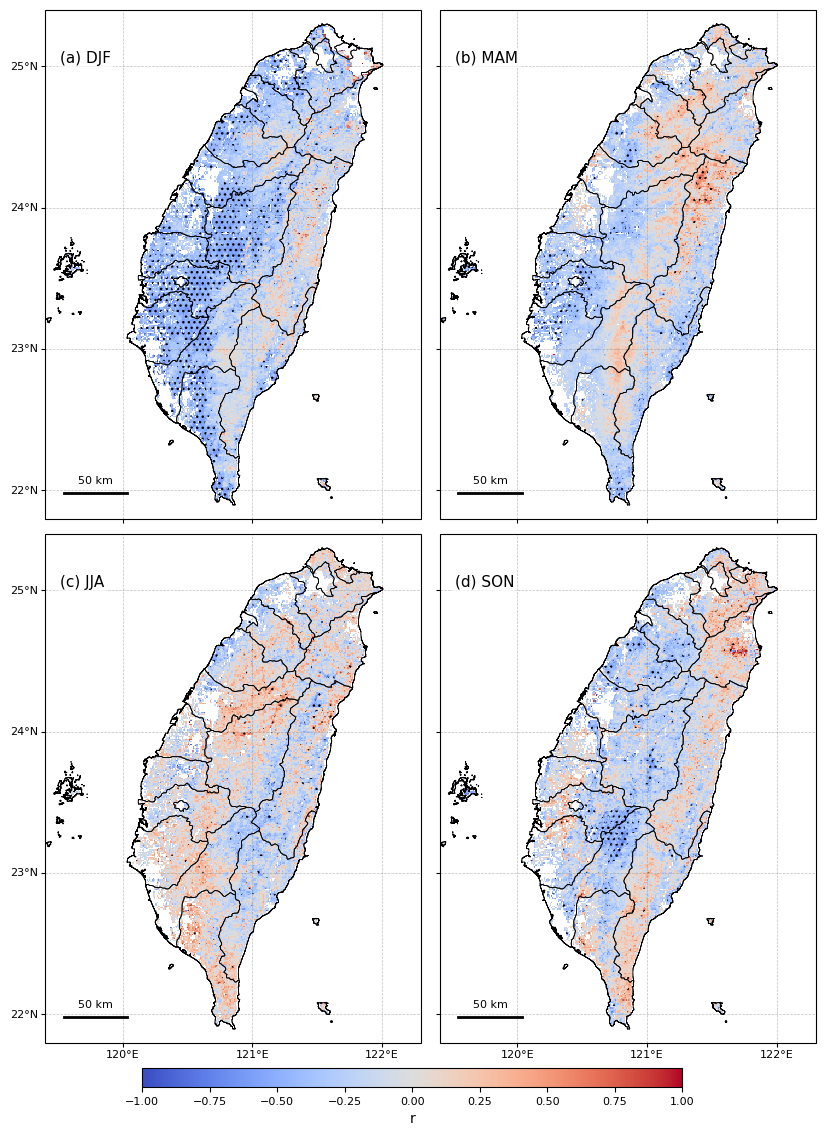

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import xarray as xr
import rioxarray
from matplotlib.cm import ScalarMappable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd

# --- 1. Define Paths and Parameters ---
DATA_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP_CORR'
SHAPEFILE_PATH = '/content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp'
OUTPUT_PLOT_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP'
if not os.path.exists(OUTPUT_PLOT_FOLDER):
    os.makedirs(OUTPUT_PLOT_FOLDER)

VAR1_NAME = "SWATI"
VAR2_NAME = "prepn"
FILE_NAMES = [
    f'{VAR1_NAME}_{VAR2_NAME}_01.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_02.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_03.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_04.tif'
]
PLOT_FILENAME = f'{VAR1_NAME}_{VAR2_NAME}.png'

# --- 2. Map for season labels ---
SEASON_MAP = {
    '01': 'DJF', '02': 'MAM', '03': 'JJA', '04': 'SON'
}

# --- 3. Scale bar helper ---
def deg_lon_to_km(lat_deg): return 111.32 * math.cos(math.radians(lat_deg))
def km_to_deg_lon(length_km, lat_deg): return length_km / deg_lon_to_km(lat_deg)

def add_scale_bar(ax, length_km=50, location=(0.04, 0.06), linewidth=2, text_dy_factor=0.01):
    ymin, ymax = ax.get_ylim()
    central_lat = (ymin + ymax) / 2
    if abs(central_lat) > 90: central_lat = 23.5

    deg_length = km_to_deg_lon(length_km, central_lat)
    xmin, xmax = ax.get_xlim()
    dx = xmax - xmin
    dy_plot = ymax - ymin

    start_lon = xmin + dx * location[0]
    start_lat = ymin + dy_plot * location[1]

    ax.plot([start_lon, start_lon + deg_length], [start_lat, start_lat],
            transform=ccrs.Geodetic(), color='black', linewidth=linewidth, zorder=5)
    ax.text(start_lon + deg_length / 2, start_lat + dy_plot * text_dy_factor,
            f'{length_km} km', ha='center', va='bottom', fontsize=8,
            transform=ccrs.Geodetic(), zorder=5)

# --- 4. Load shapefile ---
admin_boundaries = None
try:
    if os.path.exists(SHAPEFILE_PATH):
        print(f"Loading shapefile: {SHAPEFILE_PATH}")
        admin_boundaries = gpd.read_file(SHAPEFILE_PATH)
        print(f"Shapefile loaded successfully. CRS: {admin_boundaries.crs}")
        if admin_boundaries.crs is not None and admin_boundaries.crs != "EPSG:4326":
            print(f"Reprojecting shapefile to EPSG:4326 from {admin_boundaries.crs}")
            admin_boundaries = admin_boundaries.to_crs("EPSG:4326")
        if admin_boundaries.empty:
            print("Warning: Shapefile is empty. No geometries will be plotted.")
            admin_boundaries = None
    else:
        print(f"Shapefile not found at: {SHAPEFILE_PATH}")
except Exception as e:
    print(f"Error loading shapefile {SHAPEFILE_PATH}: {e}")
    admin_boundaries = None

# --- 5. Initialize Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# --- 6. Global color range settings for correlation ---
vmin, vmax = -1, 1
cmap = 'coolwarm'

# --- 7. Plot each file ---
for i, cor_file_name in enumerate(FILE_NAMES):
    ax = axes[i]
    cor_file_path = os.path.join(DATA_FOLDER, cor_file_name)

    # Derive season code and p-value filename
    try:
        parts = cor_file_name.removesuffix('.tif').split('_')
        season_code = parts[-1]
        base_name = "_".join(parts[:-1])
        pval_file_name = f"{base_name}_pval_{season_code}.tif"
        pval_file_path = os.path.join(DATA_FOLDER, pval_file_name)
    except IndexError:
        print(f"Could not parse season code from {cor_file_name}")
        ax.text(0.5, 0.5, f"Error parsing:\n{cor_file_name}", ha='center', va='center', transform=ax.transAxes, color='red')
        continue

    print(f"Processing correlation: {cor_file_path} and p-value: {pval_file_path}...")

    try:
        # Load correlation data
        cor_data_var = rioxarray.open_rasterio(cor_file_path, masked=True).squeeze()
        # Load p-value data
        pval_data_var = rioxarray.open_rasterio(pval_file_path, masked=True).squeeze()

        # Ensure CRS is PlateCarree for plotting with Cartopy
        target_crs = ccrs.PlateCarree()
        if cor_data_var.rio.crs is None:
            cor_data_var = cor_data_var.rio.write_crs("EPSG:4326", inplace=True)
        if cor_data_var.rio.crs != target_crs:
            cor_data_var = cor_data_var.rio.reproject(target_crs)

        if pval_data_var.rio.crs is None:
            pval_data_var = pval_data_var.rio.write_crs("EPSG:4326", inplace=True)
        if pval_data_var.rio.crs != target_crs:
            pval_data_var = pval_data_var.rio.reproject(target_crs)

        # Align p-value data to correlation data grid
        pval_data_var = pval_data_var.rio.reproject_match(cor_data_var)

        # Set map extent
        ax.set_extent([119.4, 122.3, 21.8, 25.4], crs=ccrs.PlateCarree())

        # Plot correlation data
        img = ax.pcolormesh(cor_data_var.x, cor_data_var.y, cor_data_var.data,
                            transform=ccrs.PlateCarree(),
                            cmap=cmap,
                            vmin=vmin, vmax=vmax,
                            shading='auto', zorder=1)

        # Add stippling for significance (p < 0.05)
        sig_mask = (pval_data_var.data < 0.05).astype(float)
        if np.any(sig_mask > 0.5):
            ax.contourf(cor_data_var.x, cor_data_var.y, sig_mask, levels=[0.5, 1.5],
                        colors='none', hatches=['...'],
                        transform=ccrs.PlateCarree(), zorder=2)

        # Add geographic features
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.0, edgecolor='black', zorder=3)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', edgecolor='dimgray', linewidth=0.0, zorder=3)

        # Overlay shapefile if loaded successfully
        if admin_boundaries is not None and not admin_boundaries.empty:
            print(f"Overlaying shapefile geometries on subplot {i+1}")
            admin_boundaries.plot(ax=ax, facecolor='none', edgecolor='black',
                                  linewidth=0.6, transform=ccrs.PlateCarree(), zorder=4)
        else:
            print(f"No shapefile geometries to plot on subplot {i+1}")

        # --- Gridlines (draw_labels=True to get original formatting) ---
        gl = ax.gridlines(draw_labels=True, linestyle='--', color='grey', linewidth=0.5, alpha=0.5, x_inline=False, y_inline=False, zorder=5)

        # Set specific tick locations for longitude and latitude
        lon_ticks = [120, 121, 122]
        lat_ticks = [22, 23, 24, 25]

        gl.xlocator = mticker.FixedLocator(lon_ticks)
        gl.ylocator = mticker.FixedLocator(lat_ticks)

        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}

        # --- Labels as per original code (only bottom and left for overall figure) ---
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = i >= 2 # True for bottom row (subplots 2, 3)
        gl.left_labels = i % 2 == 0 # True for left column (subplots 0, 2)

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        # --- Small, outside ticks on all four sides ---
        ax.set_frame_on(True) # Ensure the frame is visible for ticks
        ax.tick_params(which='major', direction='out', length=3, width=0.8, color='black',
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        # We set all label options to False here for tick_params because Cartopy's gridline labels handle the text.
        # This prevents duplicate or misaligned labels.

        # Set tick locations (important for the physical ticks to appear at gridline locations)
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())


        # Add scale bar
        add_scale_bar(ax, length_km=50, location=(0.05, 0.05), text_dy_factor=0.015)

        # Season label
        season_label = SEASON_MAP.get(season_code, season_code)
        ax.text(0.04, 0.92, f"({chr(97+i)}) {season_label}", transform=ax.transAxes,
                fontsize=11, ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.5), zorder=6)

    except FileNotFoundError as e:
        print(f"File not found: {e}")
        ax.text(0.5, 0.5, f"Missing:\n{os.path.basename(str(e))}", ha='center', va='center', transform=ax.transAxes, color='red')
    except Exception as e:
        print(f"Error processing {cor_file_name} or {pval_file_name}: {e}")
        import traceback
        traceback.print_exc()
        ax.text(0.5, 0.5, f"Error:\n{cor_file_name}", ha='center', va='center', transform=ax.transAxes, color='red')

# --- 8. Colorbar ---
cbar_ax = fig.add_axes([0.16, 0.09, 0.45, 0.016])
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('r', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# --- 9. Layout and Save ---
plt.subplots_adjust(wspace=0.2, right=0.95, bottom=0.15)
# --- 9. Layout and Save ---
# Adjust subplot spacing and margins: reduce wspace, hspace, and tighten margins
# Commented out tight_layout to avoid conflicts with Cartopy
plt.tight_layout(rect=[0, 0.10, 0.8, 1.0])

# Force figure rendering before saving
fig.canvas.draw()

full_save_path = os.path.join(OUTPUT_PLOT_FOLDER, PLOT_FILENAME)
try:
    # plt.savefig(full_save_path, dpi=300, bbox_inches=None)
    print(f"Figure saved to {full_save_path}")
except Exception as e:
    print(f"Error saving figure: {e}")

# Try to display the plot, catch any display errors
try:
    plt.show()
except Exception as e:
    print(f"Error displaying plot: {e}")
finally:
    plt.close(fig)  # Close the figure to free memory


# Mean calculation

In [ ]:
import os
import glob
import rasterio
import numpy as np
# No need for pandas for this task
# import pandas as pd
# from google.colab import drive # Assuming you are running this in Google Colab

# --- Configuration ---
# !!! IMPORTANT: Update this path to your folder in Google Drive containing the SWATI TIFF files !!!
INPUT_FOLDER_PATH = '/content/drive/MyDrive/NEW FOLDER/E' # Example: '/content/drive/MyDrive/SWATI_Data'

# Specify the folder where the resulting mean TIFF file will be saved
OUTPUT_DIR = '/content/drive/MyDrive/NEW FOLDER/MAP_CORR' # Or any other output path you prefer

# Define the range of years to process
START_YEAR = 2001
END_YEAR = 2024

# Define the target season code
TARGET_SEASON = '04'

# Ensure the output directory exists or create it
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Ensured output folder exists: {OUTPUT_DIR}")

print("-" * 30) # Separator for clarity

# --- Main Processing Logic ---
raster_data_list = []
reference_meta = None # To store metadata from the first valid raster

print(f"Calculating mean of SWATI files for Season {TARGET_SEASON} from {START_YEAR} to {END_YEAR}...")

# Loop through each year in the specified range
for year in range(START_YEAR, END_YEAR + 1):
    year_str = str(year)
    print(f"\nAttempting to process year: {year_str}, Season: {TARGET_SEASON}")

    # Construct the file pattern for the SWATI file for the current year and target season
    # Using '*' to handle potential variations in filename after the season code
    swati_file_pattern = os.path.join(INPUT_FOLDER_PATH, f'e_{year_str}_{TARGET_SEASON}*.tif')

    # Find files matching the pattern
    swati_files = glob.glob(swati_file_pattern)

    if not swati_files:
        print(f"  No SWATI file found for {year_str}_{TARGET_SEASON} matching pattern '{os.path.basename(swati_file_pattern)}'. Skipping year.")
        continue

    # Assuming only one file matches the pattern per year/season
    swati_file_path = swati_files[0]
    print(f"  Found SWATI file: {os.path.basename(swati_file_path)}")

    try:
        # Open the TIFF file using rasterio
        with rasterio.open(swati_file_path, 'r') as src:
            # Read the raster data (assuming single band data, band 1)
            current_raster_data = src.read(1)

            # Store metadata from the first successfully read raster
            if reference_meta is None:
                reference_meta = src.meta.copy()
                reference_shape = current_raster_data.shape
                print(f"  Using metadata and shape ({reference_shape}) from {os.path.basename(swati_file_path)} as reference.")
            else:
                # Check if the current raster's shape matches the reference shape
                if not (current_raster_data.shape == reference_shape):
                    print(f"  WARNING: Raster shape mismatch for {os.path.basename(swati_file_path)}. Expected {reference_shape}, got {current_raster_data.shape}. Skipping this file.")
                    continue # Skip this file and move to the next year

            # Append the raster data (NumPy array) to the list
            raster_data_list.append(current_raster_data)
            print(f"  Successfully read data for {os.path.basename(swati_file_path)}")

    except rasterio.errors.RasterioIOError as e:
        print(f"  Rasterio error opening or reading file {os.path.basename(swati_file_path)}: {e}. Skipping.")
    except Exception as e:
        print(f"  An unexpected error occurred processing file {os.path.basename(swati_file_path)}: {e}. Skipping.")

print("-" * 30) # Separator for clarity

# --- Calculate and Save Mean Raster ---
if not raster_data_list:
    print("No valid raster data was collected for the specified years and season. Cannot calculate mean.")
else:
    print(f"Collected data from {len(raster_data_list)} raster files.")

    try:
        # Stack the list of 2D arrays into a 3D array
        stacked_data = np.stack(raster_data_list, axis=0)
        print(f"Stacked data into a {stacked_data.shape} array.")

        # Calculate the mean across the first axis (the time axis)
        # Use np.nanmean to correctly handle potential NoData values (treated as NaN)
        mean_data = np.nanmean(stacked_data, axis=0)
        print(f"Calculated mean raster.")

        # Construct the output filename for the mean raster
        # Example: mean_SWATI_2001_2004_02.tif
        output_filename = f'lstdiff_{START_YEAR}_{END_YEAR}_{TARGET_SEASON}.tif'
        output_filepath = os.path.join(OUTPUT_DIR, output_filename)

        # Update the metadata for the output mean raster
        out_meta = reference_meta.copy() # Start with the reference metadata
        out_meta.update({
            "count": 1, # The output is a single band mean
            "dtype": mean_data.dtype, # Use the data type of the resulting mean array
            # You might want to explicitly set nodata if necessary,
            # e.g., "nodata": <some_value>
        })

        # Write the mean raster data to a new TIFF file
        with rasterio.open(output_filepath, 'w', **out_meta) as dest:
            dest.write(mean_data, 1) # Write the mean data to band 1

        print(f"\nSuccessfully calculated mean and saved to: {output_filepath}")

    except Exception as e:
        print(f"\nError during mean calculation or saving: {e}")

print("\nProcessing complete.")


In [ ]:
!pip install geopandas rioxarray cartopy matplotlib matplotlib-scalebar


# Final plot_Corrected plot

Loading shapefile: /content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp
Shapefile loaded successfully. CRS: EPSG:4326
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_01.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_01.tif...
Overlaying shapefile geometries on subplot 1
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_02.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_02.tif...
Overlaying shapefile geometries on subplot 2
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_03.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_03.tif...
Overlaying shapefile geometries on subplot 3
Processing correlation: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_04.tif and p-value: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/SWATI_prepn_pval_04.tif...
Overlaying shapefile geometries on subplot 4


/tmp/ipython-input-10-3421853196.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.10, 0.78, 1.0])


Figure saved to /content/drive/MyDrive/NEW FOLDER/MAP/SWATI_prepn_demo.png


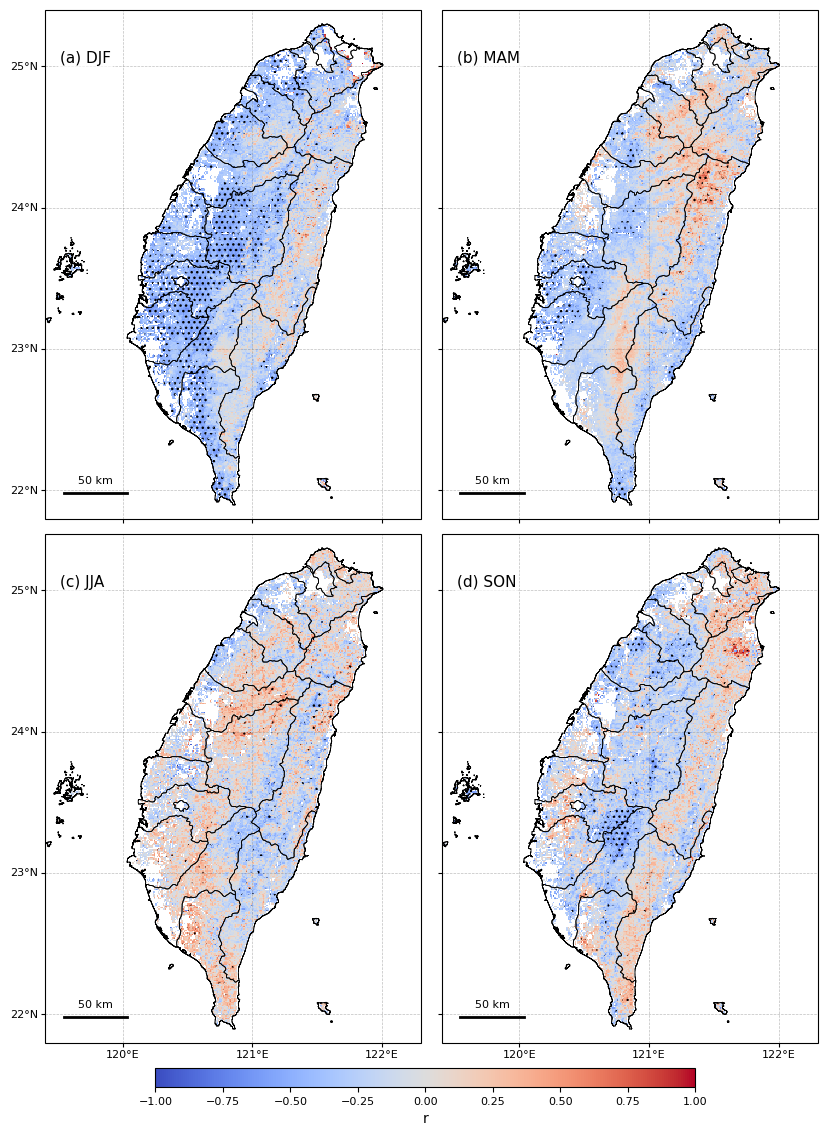

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import xarray as xr
import rioxarray
from matplotlib.cm import ScalarMappable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd

# --- 1. Define Paths and Parameters ---
DATA_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP_CORR'
SHAPEFILE_PATH = '/content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp'
OUTPUT_PLOT_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP'
if not os.path.exists(OUTPUT_PLOT_FOLDER):
    os.makedirs(OUTPUT_PLOT_FOLDER)

VAR1_NAME = "SWATI"
VAR2_NAME = "prepn"
FILE_NAMES = [
    f'{VAR1_NAME}_{VAR2_NAME}_01.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_02.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_03.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_04.tif'
]
PLOT_FILENAME = f'{VAR1_NAME}_{VAR2_NAME}_demo.png'

# --- 2. Map for season labels ---
SEASON_MAP = {
    '01': 'DJF', '02': 'MAM', '03': 'JJA', '04': 'SON'
}

# --- 3. Scale bar helper ---
def deg_lon_to_km(lat_deg): return 111.32 * math.cos(math.radians(lat_deg))
def km_to_deg_lon(length_km, lat_deg): return length_km / deg_lon_to_km(lat_deg)

def add_scale_bar(ax, length_km=50, location=(0.04, 0.06), linewidth=2, text_dy_factor=0.01):
    ymin, ymax = ax.get_ylim()
    central_lat = (ymin + ymax) / 2
    if abs(central_lat) > 90: central_lat = 23.5

    deg_length = km_to_deg_lon(length_km, central_lat)
    xmin, xmax = ax.get_xlim()
    dx = xmax - xmin
    dy_plot = ymax - ymin

    # Calculate start_lon and start_lat based on location
    start_lon = xmin + dx * location[0]
    start_lat = ymin + dy_plot * location[1]

    ax.plot([start_lon, start_lon + deg_length], [start_lat, start_lat],
            transform=ccrs.Geodetic(), color='black', linewidth=linewidth, zorder=5)
    ax.text(start_lon + deg_length / 2, start_lat + dy_plot * text_dy_factor,
            f'{length_km} km', ha='center', va='bottom', fontsize=8,
            transform=ccrs.Geodetic(), zorder=5)

# --- 4. Load shapefile ---
admin_boundaries = None
try:
    if os.path.exists(SHAPEFILE_PATH):
        print(f"Loading shapefile: {SHAPEFILE_PATH}")
        admin_boundaries = gpd.read_file(SHAPEFILE_PATH)
        print(f"Shapefile loaded successfully. CRS: {admin_boundaries.crs}")
        if admin_boundaries.crs is not None and admin_boundaries.crs != "EPSG:4326":
            print(f"Reprojecting shapefile to EPSG:4326 from {admin_boundaries.crs}")
            admin_boundaries = admin_boundaries.to_crs("EPSG:4326")
        if admin_boundaries.empty:
            print("Warning: Shapefile is empty. No geometries will be plotted.")
            admin_boundaries = None
    else:
        print(f"Shapefile not found at: {SHAPEFILE_PATH}")
except Exception as e:
    print(f"Error loading shapefile {SHAPEFILE_PATH}: {e}")
    admin_boundaries = None

# --- 5. Initialize Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# --- 6. Global color range settings for correlation ---
vmin, vmax = -1, 1
cmap = 'coolwarm'

# --- 7. Plot each file ---
for i, cor_file_name in enumerate(FILE_NAMES):
    ax = axes[i]
    cor_file_path = os.path.join(DATA_FOLDER, cor_file_name)

    # Derive season code and p-value filename
    try:
        parts = cor_file_name.removesuffix('.tif').split('_')
        season_code = parts[-1]
        base_name = "_".join(parts[:-1])
        pval_file_name = f"{base_name}_pval_{season_code}.tif"
        pval_file_path = os.path.join(DATA_FOLDER, pval_file_name)
    except IndexError:
        print(f"Could not parse season code from {cor_file_name}")
        ax.text(0.5, 0.5, f"Error parsing:\n{cor_file_name}", ha='center', va='center', transform=ax.transAxes, color='red')
        continue

    print(f"Processing correlation: {cor_file_path} and p-value: {pval_file_path}...")

    try:
        # Load correlation data
        cor_data_var = rioxarray.open_rasterio(cor_file_path, masked=True).squeeze()
        # Load p-value data
        pval_data_var = rioxarray.open_rasterio(pval_file_path, masked=True).squeeze()

        # Ensure CRS is PlateCarree for plotting with Cartopy
        target_crs = ccrs.PlateCarree()
        if cor_data_var.rio.crs is None:
            cor_data_var = cor_data_var.rio.write_crs("EPSG:4326", inplace=True)
        if cor_data_var.rio.crs != target_crs:
            cor_data_var = cor_data_var.rio.reproject(target_crs)

        if pval_data_var.rio.crs is None:
            pval_data_var = pval_data_var.rio.write_crs("EPSG:4326", inplace=True)
        if pval_data_var.rio.crs != target_crs:
            pval_data_var = pval_data_var.rio.reproject(target_crs)

        # Align p-value data to correlation data grid
        pval_data_var = pval_data_var.rio.reproject_match(cor_data_var)

        # Set map extent
        ax.set_extent([119.4, 122.3, 21.8, 25.4], crs=ccrs.PlateCarree())

        # Plot correlation data
        img = ax.pcolormesh(cor_data_var.x, cor_data_var.y, cor_data_var.data,
                            transform=ccrs.PlateCarree(),
                            cmap=cmap,
                            vmin=vmin, vmax=vmax,
                            shading='auto', zorder=1)

        # Add stippling for significance (p < 0.05)
        sig_mask = (pval_data_var.data < 0.05).astype(float)
        if np.any(sig_mask > 0.5):
            ax.contourf(cor_data_var.x, cor_data_var.y, sig_mask, levels=[0.5, 1.5],
                        colors='none', hatches=['...'],
                        transform=ccrs.PlateCarree(), zorder=2)

        # Add geographic features
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.0, edgecolor='black', zorder=3)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', edgecolor='dimgray', linewidth=0.0, zorder=3)

        # Overlay shapefile if loaded successfully
        if admin_boundaries is not None and not admin_boundaries.empty:
            print(f"Overlaying shapefile geometries on subplot {i+1}")
            admin_boundaries.plot(ax=ax, facecolor='none', edgecolor='black',
                                  linewidth=0.6, transform=ccrs.PlateCarree(), zorder=4)
        else:
            print(f"No shapefile geometries to plot on subplot {i+1}")

        # --- Gridlines (draw_labels=True to get original formatting) ---
        gl = ax.gridlines(draw_labels=True, linestyle='--', color='grey', linewidth=0.5, alpha=0.5, x_inline=False, y_inline=False, zorder=5)

        # Set specific tick locations for longitude and latitude
        lon_ticks = [120, 121, 122]
        lat_ticks = [22, 23, 24, 25]

        gl.xlocator = mticker.FixedLocator(lon_ticks)
        gl.ylocator = mticker.FixedLocator(lat_ticks)

        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}

        # --- Labels as per original code (only bottom and left for overall figure) ---
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = i >= 2  # True for bottom row (subplots 2, 3)
        gl.left_labels = i % 2 == 0  # True for left column (subplots 0, 2)

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        # --- Small, outside ticks on all four sides ---
        ax.set_frame_on(True)
        ax.tick_params(which='major', direction='out', length=3, width=0.8, color='black',
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

        # Add scale bar
        add_scale_bar(ax, length_km=50, location=(0.05, 0.05), text_dy_factor=0.015)

        # Season label
        season_label = SEASON_MAP.get(season_code, season_code)
        ax.text(0.04, 0.92, f"({chr(97+i)}) {season_label}", transform=ax.transAxes,
                fontsize=11, ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.5), zorder=6)

    except FileNotFoundError as e:
        print(f"File not found: {e}")
        ax.text(0.5, 0.5, f"Missing:\n{os.path.basename(str(e))}", ha='center', va='center', transform=ax.transAxes, color='red')
    except Exception as e:
        print(f"Error processing {cor_file_name} or {pval_file_name}: {e}")
        import traceback
        traceback.print_exc()
        ax.text(0.5, 0.5, f"Error:\n{cor_file_name}", ha='center', va='center', transform=ax.transAxes, color='red')

# --- 8. Colorbar ---
cbar_ax = fig.add_axes([0.16, 0.09, 0.45, 0.016])  # Adjusted width from 0.45 to 0.650.16, 0.09, 0.45, 0.016
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('r', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# --- 9. Layout and Save ---
plt.subplots_adjust(wspace=0.2, hspace=0.2, right=0.95, top=0.95, bottom=0.15)
plt.tight_layout(rect=[0, 0.10, 0.78, 1.0])

# Force figure rendering before saving (wspace=0.2, right=0.95, bottom=0.15)
fig.canvas.draw()

full_save_path = os.path.join(OUTPUT_PLOT_FOLDER, PLOT_FILENAME)
try:
    plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to {full_save_path}")
except Exception as e:
    print(f"Error saving figure: {e}")

# Try to display the plot, catch any display errors
try:
    plt.show()
except Exception as e:
    print(f"Error displaying plot: {e}")
finally:
    plt.close(fig)  # Close the figure to free memory

# SWATI Mean

Loading shapefile: /content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp
Shapefile loaded successfully. CRS: EPSG:4326
Global min: 0.1610, Global max: 0.7362
Processing file: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/TVPDIC_2001_2022_01.tif...
Overlaying shapefile geometries on subplot 1
Processing file: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/TVPDIC_2001_2022_02.tif...
Overlaying shapefile geometries on subplot 2
Processing file: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/TVPDIC_2001_2022_03.tif...
Overlaying shapefile geometries on subplot 3
Processing file: /content/drive/MyDrive/NEW FOLDER/MAP_CORR/TVPDIC_2001_2022_04.tif...
Overlaying shapefile geometries on subplot 4


/tmp/ipython-input-26-1675468813.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.10, 0.8, 1.0])


Figure saved to /content/drive/MyDrive/NEW FOLDER/MAP/TVPDIC_2001_2022.png


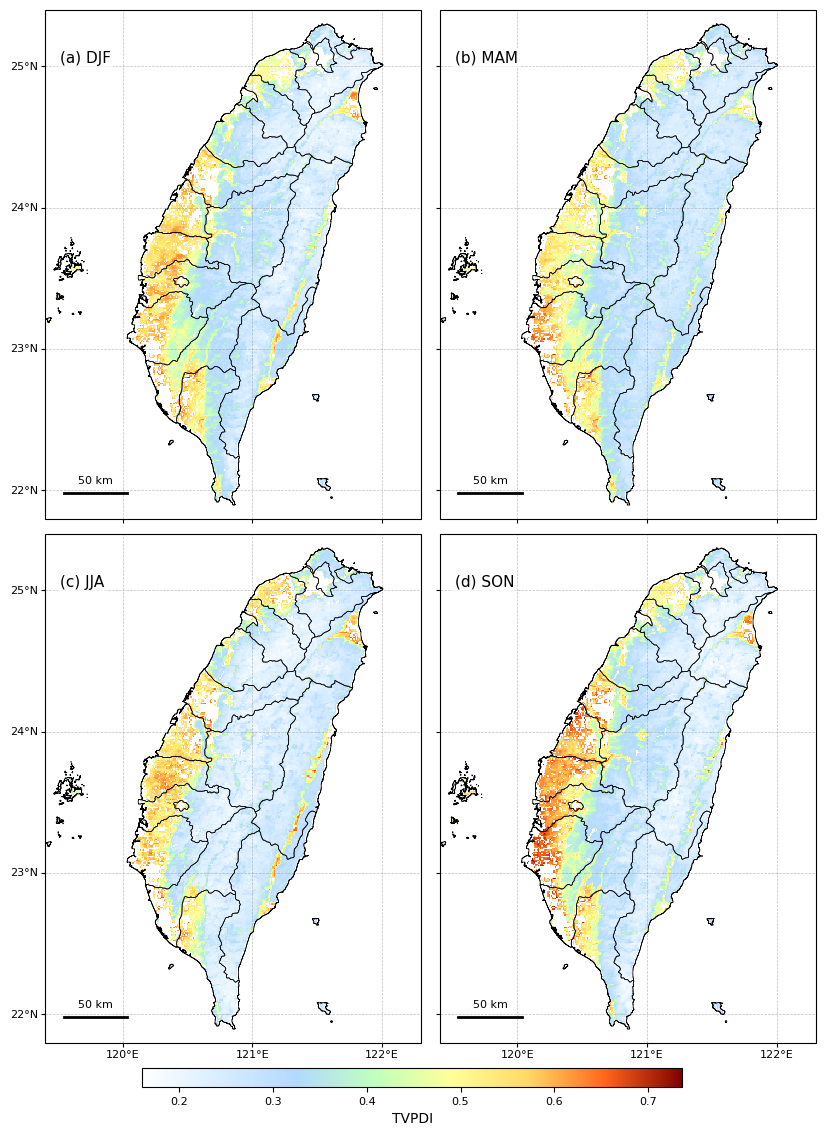

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import rioxarray
from matplotlib.cm import ScalarMappable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
import matplotlib.colors as mcolors # Import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap # Import LinearSegmentedColormap
# --- 1. Define Paths and Parameters ---
DATA_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP_CORR'
SHAPEFILE_PATH = '/content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp'
OUTPUT_PLOT_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP'
if not os.path.exists(OUTPUT_PLOT_FOLDER):
    os.makedirs(OUTPUT_PLOT_FOLDER)

VAR1_NAME = "TVPDIC"
VAR2_NAME = "2001_2022"
FILE_NAMES = [
    f'{VAR1_NAME}_{VAR2_NAME}_01.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_02.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_03.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_04.tif'
]
PLOT_FILENAME = f'{VAR1_NAME}_{VAR2_NAME}.png'

# --- 2. Map for season labels ---
SEASON_MAP = {
    '01': 'DJF', '02': 'MAM', '03': 'JJA', '04': 'SON'
}

# --- 3. Scale bar helper ---
def deg_lon_to_km(lat_deg): return 111.32 * math.cos(math.radians(lat_deg))
def km_to_deg_lon(length_km, lat_deg): return length_km / deg_lon_to_km(lat_deg)

def add_scale_bar(ax, length_km=50, location=(0.04, 0.06), linewidth=2, text_dy_factor=0.01):
    ymin, ymax = ax.get_ylim()
    central_lat = (ymin + ymax) / 2
    if abs(central_lat) > 90: central_lat = 23.5

    deg_length = km_to_deg_lon(length_km, central_lat)
    xmin, xmax = ax.get_xlim()
    dx = xmax - xmin
    dy_plot = ymax - ymin

    start_lon = xmin + dx * location[0]
    start_lat = ymin + dy_plot * location[1]

    ax.plot([start_lon, start_lon + deg_length], [start_lat, start_lat],
            transform=ccrs.Geodetic(), color='black', linewidth=linewidth, zorder=5)
    ax.text(start_lon + deg_length / 2, start_lat + dy_plot * text_dy_factor,
            f'{length_km} km', ha='center', va='bottom', fontsize=8,
            transform=ccrs.Geodetic(), zorder=5)

# --- 4. Load shapefile ---
admin_boundaries = None
try:
    if os.path.exists(SHAPEFILE_PATH):
        print(f"Loading shapefile: {SHAPEFILE_PATH}")
        admin_boundaries = gpd.read_file(SHAPEFILE_PATH)
        print(f"Shapefile loaded successfully. CRS: {admin_boundaries.crs}")
        if admin_boundaries.crs is not None and admin_boundaries.crs != "EPSG:4326":
            print(f"Reprojecting shapefile to EPSG:4326 from {admin_boundaries.crs}")
            admin_boundaries = admin_boundaries.to_crs("EPSG:4326")
        if admin_boundaries.empty:
            print("Warning: Shapefile is empty. No geometries will be plotted.")
            admin_boundaries = None
    else:
        print(f"Shapefile not found at: {SHAPEFILE_PATH}")
except Exception as e:
    print(f"Error loading shapefile {SHAPEFILE_PATH}: {e}")
    admin_boundaries = None

# --- 5. Calculate global min and max for consistent color scaling ---
global_data = []
for file_name in FILE_NAMES:
    file_path = os.path.join(DATA_FOLDER, file_name)
    try:
        data_var = rioxarray.open_rasterio(file_path, masked=True).squeeze()
        # Ensure proper CRS
        if data_var.rio.crs is None:
            data_var = data_var.rio.write_crs("EPSG:4326", inplace=True)
        elif data_var.rio.crs != ccrs.PlateCarree():
            data_var = data_var.rio.reproject(ccrs.PlateCarree())
        # Collect non-NaN values
        valid_values = data_var.values[~np.isnan(data_var.values)]
        if valid_values.size > 0:
            global_data.append(valid_values.flatten())
        else:
            print(f"Warning: All values are NaN in {file_name}")
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

# Compute global min and max
if global_data:
    all_values = np.concatenate(global_data)
    vmin, vmax = np.nanmin(all_values), np.nanmax(all_values)
    print(f"Global min: {vmin:.4f}, Global max: {vmax:.4f}")
else:
    print("No valid data found. Using default min/max.")
    vmin, vmax = -1, 1  # Fallback values

# # --- 7. Global color settings ---
# cmap = 'coolwarm'
# # cmap = 'Spectral_r'

colors = [
      (1.0, 1.0, 1.0),      # 1: White
      (0.85, 0.93, 1.0),    # 2: Very Light Blue
      (0.7, 0.85, 1.0),     # 3: Light Blue
      (0.75, 1.0, 0.75),    # 4: Light Green
      (1.0, 1.0, 0.6),      # 5: Light Yellow
      (1.0, 0.85, 0.4),     # 6: Goldenrod / Light Orange
      (1.0, 0.4, 0.1),      # 7: Orange-Red
      (0.5, 0.0, 0.0)       # 8: Dark Red / Maroon
]

cmap = LinearSegmentedColormap.from_list("WhiteBlueGreenYellowRed", colors, N=1024)


# colors = [
#     (0.0, 0.0, 0.5),     # dark blue
#     (0.2, 0.4, 0.8),     # medium blue
#     (0.6, 0.8, 1.0),     # light blue
#     (0.85, 0.93, 1.0),   # very light blue
#     (0.95, 0.95, 0.95),  # light gray near white (new midpoint level)
#     (1.0, 1.0, 1.0),     # pure white (exact zero)
#     (1.0, 0.85, 0.8),    # very light red
#     (1.0, 0.4, 0.1),     # orange-red
#     (0.5, 0.0, 0.0)      # dark red
# ]

# # Create the custom colormap
# cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=1024)
# --- 6. Initialize Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()


# --- 8. Plot each file ---
for i, file_name in enumerate(FILE_NAMES):
    ax = axes[i]
    file_path = os.path.join(DATA_FOLDER, file_name)

    # Derive season code
    try:
        season_code = file_name.removesuffix('.tif').split('_')[-1]
    except IndexError:
        print(f"Could not parse season code from {file_name}")
        ax.text(0.5, 0.5, f"Error parsing:\n{file_name}", ha='center', va='center', transform=ax.transAxes, color='red')
        continue

    print(f"Processing file: {file_path}...")

    try:
        # Load data
        data_var = rioxarray.open_rasterio(file_path, masked=True).squeeze()

        # Ensure CRS is PlateCarree for plotting with Cartopy
        target_crs = ccrs.PlateCarree()
        if data_var.rio.crs is None:
            data_var = data_var.rio.write_crs("EPSG:4326", inplace=True)
        if data_var.rio.crs != target_crs:
            data_var = data_var.rio.reproject(target_crs)

        # Set map extent
        ax.set_extent([119.4, 122.3, 21.8, 25.4], crs=ccrs.PlateCarree())

        # Plot data
        img = ax.pcolormesh(data_var.x, data_var.y, data_var.data,
                            transform=ccrs.PlateCarree(),
                            cmap=cmap,
                            vmin=vmin, vmax=vmax,
                            shading='auto', zorder=1)

        # Add geographic features
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.0, edgecolor='black', zorder=3)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', edgecolor='dimgray', linewidth=0.0, zorder=3)

        # Overlay shapefile if loaded successfully
        if admin_boundaries is not None and not admin_boundaries.empty:
            print(f"Overlaying shapefile geometries on subplot {i+1}")
            admin_boundaries.plot(ax=ax, facecolor='none', edgecolor='black',
                                  linewidth=0.5, transform=ccrs.PlateCarree(), zorder=4)
        else:
            print(f"No shapefile geometries to plot on subplot {i+1}")

        # --- Gridlines ---
        gl = ax.gridlines(draw_labels=True, linestyle='--', color='grey', linewidth=0.5, alpha=0.5, x_inline=False, y_inline=False, zorder=5)

        # Set specific tick locations
        lon_ticks = [120, 121, 122]
        lat_ticks = [22, 23, 24, 25]

        gl.xlocator = mticker.FixedLocator(lon_ticks)
        gl.ylocator = mticker.FixedLocator(lat_ticks)

        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}

        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = i >= 2  # True for bottom row
        gl.left_labels = i % 2 == 0  # True for left column

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

        # --- Small, outside ticks ---
        ax.set_frame_on(True)
        ax.tick_params(which='major', direction='out', length=3, width=0.8, color='black',
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

        # Add scale bar
        add_scale_bar(ax, length_km=50, location=(0.05, 0.05), text_dy_factor=0.015)

        # Season label
        season_label = SEASON_MAP.get(season_code, season_code)
        ax.text(0.04, 0.92, f"({chr(97+i)}) {season_label}", transform=ax.transAxes,
                fontsize=11, ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.5), zorder=6)

    except FileNotFoundError as e:
        print(f"File not found: {e}")
        ax.text(0.5, 0.5, f"Missing:\n{os.path.basename(str(e))}", ha='center', va='center', transform=ax.transAxes, color='red')
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        ax.text(0.5, 0.5, f"Error:\n{file_name}", ha='center', va='center', transform=ax.transAxes, color='red')

# --- 9. Colorbar ---
cbar_ax = fig.add_axes([0.16, 0.09, 0.45, 0.016])
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('TVPDI', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# --- 9. Layout and Save ---
plt.subplots_adjust(wspace=0.2, right=0.95, bottom=0.15)
# Commented out tight_layout to avoid conflicts with Cartopy
plt.tight_layout(rect=[0, 0.10, 0.8, 1.0])

# Force figure rendering before saving
fig.canvas.draw()

full_save_path = os.path.join(OUTPUT_PLOT_FOLDER, PLOT_FILENAME)
try:
    plt.savefig(full_save_path, dpi=300)
    print(f"Figure saved to {full_save_path}")
except Exception as e:
    print(f"Error saving figure: {e}")

# Try to display the plot
try:
    plt.show()
except Exception as e:
    print(f"Error displaying plot: {e}")
finally:
    plt.close(fig)

# LST diff plot

Loading shapefile: /content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp
Shapefile loaded successfully. Original CRS: EPSG:4326
Shapefile cleaned and ready. Current CRS: EPSG:4326
Original CRS for lstdiff_2001_2024_01.tif: EPSG:32651
Reprojected lstdiff_2001_2024_01.tif to EPSG:4326
Original CRS for lstdiff_2001_2024_02.tif: EPSG:32651
Reprojected lstdiff_2001_2024_02.tif to EPSG:4326
Original CRS for lstdiff_2001_2024_03.tif: EPSG:32651
Reprojected lstdiff_2001_2024_03.tif to EPSG:4326
Original CRS for lstdiff_2001_2024_04.tif: EPSG:32651
Reprojected lstdiff_2001_2024_04.tif to EPSG:4326
Global mean: -0.0002, std: 0.2751
Calculated vmin: -0.5504, vmax: 0.5500
Plotting data for: lstdiff_2001_2024_01.tif...
Overlaying shapefile geometries on subplot 1
Plotting data for: lstdiff_2001_2024_02.tif...
Overlaying shapefile geometries on subplot 2
Plotting data for: lstdiff_2001_2024_03.tif...
Overlaying shapefile geometries on subplot 3
Plotting data for: lstdiff_2001_2024_04.tif...
Overlayin

/tmp/ipython-input-4-1581951031.py:259: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.10, 0.8, 1.0])


Figure saved to /content/drive/MyDrive/NEW FOLDER/MAP/lstdiff_2001_2024_new.png


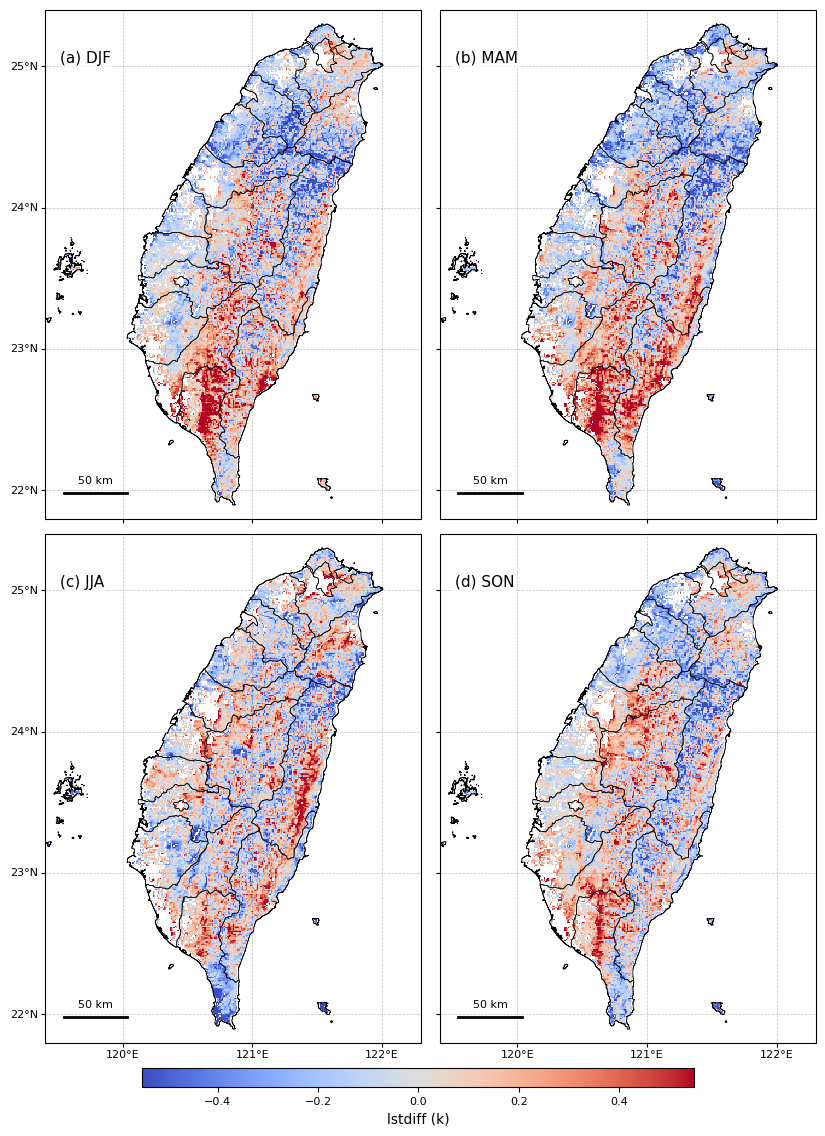

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import rioxarray
from matplotlib.cm import ScalarMappable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
import matplotlib.colors as mcolors # Import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap # Import LinearSegmentedColormap

# --- 1. Define Paths and Parameters ---
DATA_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP_CORR'
SHAPEFILE_PATH = '/content/drive/MyDrive/TAIWAN_ADMIN/gadm41_TWN_2.shp'
OUTPUT_PLOT_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP'
if not os.path.exists(OUTPUT_PLOT_FOLDER):
    os.makedirs(OUTPUT_PLOT_FOLDER)

VAR1_NAME = "lstdiff"
VAR2_NAME = "2001_2024"
FILE_NAMES = [
    f'{VAR1_NAME}_{VAR2_NAME}_01.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_02.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_03.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_04.tif'
]
PLOT_FILENAME = f'{VAR1_NAME}_{VAR2_NAME}_new.png'

# --- 2. Map for season labels ---
SEASON_MAP = {
    '01': 'DJF', '02': 'MAM', '03': 'JJA', '04': 'SON'
}

# --- 3. Scale bar helper (for PlateCarree) ---
def deg_lon_to_km(lat_deg):
    """Converts a degree of longitude at a given latitude to kilometers."""
    return 111.32 * math.cos(math.radians(lat_deg))

def km_to_deg_lon(length_km, lat_deg):
    """Converts a length in kilometers at a given latitude to degrees of longitude."""
    if deg_lon_to_km(lat_deg) == 0: # Avoid division by zero at poles, though unlikely for Taiwan
        return length_km / 0.001 # A very small number
    return length_km / deg_lon_to_km(lat_deg)

def add_scale_bar(ax, length_km=50, location=(0.04, 0.06), linewidth=2, text_dy_factor=0.01):
    """Adds a scale bar to a Cartopy PlateCarree axis."""
    # Get current plot limits in data coordinates (degrees)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Determine a representative latitude for scale bar calculation
    central_lat = (ymin + ymax) / 2
    if abs(central_lat) > 90: central_lat = 23.5 # Fallback for extreme cases

    # Convert desired length in km to degrees longitude
    deg_length = km_to_deg_lon(length_km, central_lat)

    # Calculate plot dimensions for relative positioning
    dx_plot = xmax - xmin
    dy_plot = ymax - ymin

    # Calculate starting longitude and latitude for the scale bar
    start_lon = xmin + dx_plot * location[0]
    start_lat = ymin + dy_plot * location[1]

    # Plot the scale bar line
    ax.plot([start_lon, start_lon + deg_length], [start_lat, start_lat],
            transform=ccrs.Geodetic(), color='black', linewidth=linewidth, zorder=5)

    # Add the text label for the scale bar
    ax.text(start_lon + deg_length / 2, start_lat + dy_plot * text_dy_factor,
            f'{length_km} km', ha='center', va='bottom', fontsize=8,
            transform=ccrs.Geodetic(), zorder=5)


# --- 4. Load and Clean Shapefile ---
admin_gdf = None
try:
    if os.path.exists(SHAPEFILE_PATH):
        print(f"Loading shapefile: {SHAPEFILE_PATH}")
        admin_gdf = gpd.read_file(SHAPEFILE_PATH)
        print(f"Shapefile loaded successfully. Original CRS: {admin_gdf.crs}")

        # Ensure shapefile is in EPSG:4326 for plotting with PlateCarree
        if admin_gdf.crs is None or admin_gdf.crs != "EPSG:4326":
            print(f"Reprojecting shapefile to EPSG:4326 from {admin_gdf.crs}")
            admin_gdf = admin_gdf.set_crs("EPSG:4326", allow_override=True) if admin_gdf.crs is None else admin_gdf.to_crs("EPSG:4326")

        # Clean shapefile geometries
        admin_gdf = admin_gdf[admin_gdf.is_valid & ~admin_gdf.geometry.is_empty & admin_gdf.geometry.notnull()]

        if admin_gdf.empty:
            print("Warning: Cleaned shapefile is empty. No geometries will be plotted.")
            admin_gdf = None
        else:
            print(f"Shapefile cleaned and ready. Current CRS: {admin_gdf.crs}")

    else:
        print(f"Shapefile not found at: {SHAPEFILE_PATH}. Skipping shapefile overlay.")
except Exception as e:
    print(f"Error loading or processing shapefile {SHAPEFILE_PATH}: {e}")
    admin_gdf = None


# --- 5. Calculate Global Mean/Std Range for consistent color scaling ---
data_rasters = [] # To store xarray.DataArray objects
all_raster_values = [] # To store flattened numpy arrays of values for global stats

for file_name in FILE_NAMES:
    file_path = os.path.join(DATA_FOLDER, file_name)
    try:
        # Load data, squeeze to remove singleton dimensions, and ensure masking
        da = rioxarray.open_rasterio(file_path, masked=True).squeeze()
        print(f"Original CRS for {file_name}: {da.rio.crs}")

        # Ensure the raster has a CRS. If not, assume it's EPSG:32651 as per previous script.
        if da.rio.crs is None:
            print(f"Warning: No CRS found for {file_name}, assuming EPSG:32651 for reprojection.")
            da = da.rio.set_crs("EPSG:32651", inplace=True)

        # Reproject to EPSG:4326 for plotting with PlateCarree
        da = da.rio.reproject("EPSG:4326")
        print(f"Reprojected {file_name} to EPSG:4326")
        data_rasters.append(da)

        # Collect non-NaN values for global statistics
        valid_values = da.values[~np.isnan(da.values)]
        if valid_values.size > 0:
            all_raster_values.append(valid_values.flatten())
        else:
            print(f"Warning: All values are NaN in {file_name} after reprojection.")
    except Exception as e:
        print(f"Error reading or reprojecting {file_name}: {e}")

# Compute global mean, std, and min/max for color scale
vmin, vmax = None, None
if all_raster_values:
    combined_values = np.concatenate(all_raster_values)
    vmean = np.nanmean(combined_values)
    vstd = np.nanstd(combined_values)
    vmin = vmean - 2 * vstd
    vmax = vmean + 2 * vstd
    print(f"Global mean: {vmean:.4f}, std: {vstd:.4f}")
    print(f"Calculated vmin: {vmin:.4f}, vmax: {vmax:.4f}")
else:
    print("No valid raster data found for global statistics. Using default min/max.")
    vmin, vmax = -1, 1  # Fallback values if no data is loaded

# --- 6. Global color settings ---
cmap = 'coolwarm'
# colors = [
#       (1.0, 1.0, 1.0),      # 1: White
#       (0.85, 0.93, 1.0),    # 2: Very Light Blue
#       (0.7, 0.85, 1.0),     # 3: Light Blue
#       (0.75, 1.0, 0.75),    # 4: Light Green
#       (1.0, 1.0, 0.6),      # 5: Light Yellow
#       (1.0, 0.85, 0.4),     # 6: Goldenrod / Light Orange
#       (1.0, 0.4, 0.1),      # 7: Orange-Red
#       (0.5, 0.0, 0.0)       # 8: Dark Red / Maroon
# ]

# cmap = LinearSegmentedColormap.from_list("WhiteBlueGreenYellowRed", colors, N=1024)

# --- 7. Initialize Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# --- 8. Plot each file ---
for i, da in enumerate(data_rasters): # Iterate through the loaded DataArray objects
    ax = axes[i]
    file_name = FILE_NAMES[i] # Get original filename to derive season code

    # Derive season code
    try:
        season_code = file_name.removesuffix('.tif').split('_')[-1]
    except IndexError:
        print(f"Could not parse season code from {file_name}")
        ax.text(0.5, 0.5, f"Error parsing:\n{file_name}", ha='center', va='center', transform=ax.transAxes, color='red')
        continue

    print(f"Plotting data for: {file_name}...")

    # Set map extent (common for all subplots)
    ax.set_extent([119.4, 122.3, 21.8, 25.4], crs=ccrs.PlateCarree())

    # Plot data
    img = ax.pcolormesh(da.x, da.y, da.data,
                        transform=ccrs.PlateCarree(),
                        cmap=cmap,
                        vmin=vmin, vmax=vmax, # Use globally calculated min/max
                        shading='auto', zorder=1)

    # # Add geographic features
    # ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.0, edgecolor='black', zorder=3) # Increased linewidth
    # ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', edgecolor='dimgray', linewidth=0.5, zorder=3) # Increased linewidth

    # Overlay shapefile if loaded successfully
    if admin_gdf is not None and not admin_gdf.empty:
        print(f"Overlaying shapefile geometries on subplot {i+1}")
        admin_gdf.plot(ax=ax, facecolor='none', edgecolor='black',
                        linewidth=0.5, transform=ccrs.PlateCarree(), zorder=4)
    else:
        print(f"No shapefile geometries to plot on subplot {i+1}")

    # --- Gridlines ---
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='grey', linewidth=0.5, alpha=0.5, x_inline=False, y_inline=False, zorder=5)

    # Set specific tick locations
    lon_ticks = [120, 121, 122]
    lat_ticks = [22, 23, 24, 25]

    gl.xlocator = mticker.FixedLocator(lon_ticks)
    gl.ylocator = mticker.FixedLocator(lat_ticks)

    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = i >= 2  # True for bottom row
    gl.left_labels = i % 2 == 0  # True for left column

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # --- Small, outside ticks (for frame) ---
    ax.set_frame_on(True)
    ax.tick_params(which='major', direction='out', length=3, width=0.8, color='black',
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())


    # Add scale bar
    add_scale_bar(ax, length_km=50, location=(0.05, 0.05), text_dy_factor=0.015)

    # Season label
    season_label = SEASON_MAP.get(season_code, season_code)
    ax.text(0.04, 0.92, f"({chr(97+i)}) {season_label}", transform=ax.transAxes,
            fontsize=11, ha='left', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.5), zorder=6)


# --- 9. Colorbar ---
# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([0.16, 0.09, 0.46, 0.016]) # Adjusted position and width
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) # Important for ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(f'{VAR1_NAME.lower()} (k)', fontsize=10) # Label as per first script
cbar.ax.tick_params(labelsize=8)

# --- 9. Layout and Save ---
plt.subplots_adjust(wspace=0.2, right=0.95, bottom=0.15)
# Commented out tight_layout to avoid conflicts with Cartopy
plt.tight_layout(rect=[0, 0.10, 0.8, 1.0])

# Force figure rendering before saving
fig.canvas.draw()

full_save_path = os.path.join(OUTPUT_PLOT_FOLDER, PLOT_FILENAME)
try:
    plt.savefig(full_save_path, dpi=300)
    print(f"Figure saved to {full_save_path}")
except Exception as e:
    print(f"Error saving figure: {e}")

# Try to display the plot
try:
    plt.show()
except Exception as e:
    print(f"Error displaying plot: {e}")
finally:
    plt.close(fig)

# oginal code

Processing correlation: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_01.tif and p-value: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_pval_01.tif...
Processing correlation: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_02.tif and p-value: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_pval_02.tif...
Processing correlation: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_03.tif and p-value: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_pval_03.tif...
Processing correlation: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_04.tif and p-value: /content/drive/MyDrive/NEW FOLDER/CORRELATION/SWATI_TVPDI_pval_04.tif...


<ipython-input-15-1893915172>:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 0.8, 1])


Figure saved to /content/drive/MyDrive/NEW FOLDER/MAP/SWATI_TVPDI_pvalue95star.png


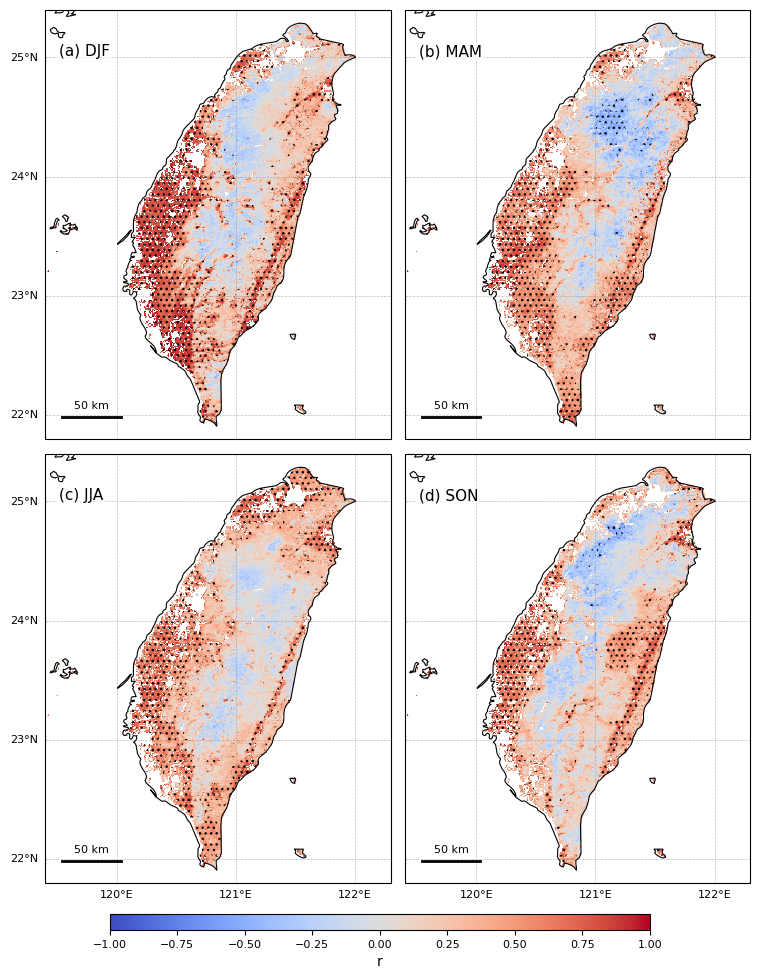

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import xarray as xr
import rioxarray
from matplotlib.cm import ScalarMappable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# --- 1. Define Paths and Parameters ---
DATA_FOLDER = '/content/drive/MyDrive/NEW FOLDER/CORRELATION' # Folder with correlation & p-value TIFFs
OUTPUT_PLOT_FOLDER = '/content/drive/MyDrive/NEW FOLDER/MAP'
if not os.path.exists(OUTPUT_PLOT_FOLDER):
    os.makedirs(OUTPUT_PLOT_FOLDER)

# Corresponds to the correlation coefficient files (e.g., SWATI_TVPDI_01.tif)
VAR1_NAME = "SWATI"
VAR2_NAME = "TVPDI"
FILE_NAMES = [
    f'{VAR1_NAME}_{VAR2_NAME}_01.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_02.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_03.tif',
    f'{VAR1_NAME}_{VAR2_NAME}_04.tif'
]
PLOT_FILENAME = f'{VAR1_NAME}_{VAR2_NAME}_pvalue95star.png' # Output plot filename

# --- 2. Map for season labels ---
SEASON_MAP = {
    '01': 'DJF', '02': 'MAM', '03': 'JJA', '04': 'SON'
}

# --- 3. Scale bar helper ---
def deg_lon_to_km(lat_deg): return 111.32 * math.cos(math.radians(lat_deg))
def km_to_deg_lon(length_km, lat_deg): return length_km / deg_lon_to_km(lat_deg)

def add_scale_bar(ax, length_km=50, location=(0.04, 0.06), linewidth=2, text_dy_factor=0.01):
    # Estimate a central latitude for the scale bar calculation from the extent
    ymin, ymax = ax.get_ylim()
    central_lat = (ymin + ymax) / 2
    # If extent is global or very large, default to a reasonable latitude
    if abs(central_lat) > 90: central_lat = 23.5


    deg_length = km_to_deg_lon(length_km, central_lat)
    xmin, xmax = ax.get_xlim()
    dx = xmax - xmin
    dy_plot = ymax-ymin # plot y range

    # Convert location from relative axes coords to data coords
    start_lon = xmin + dx * location[0]
    start_lat = ymin + dy_plot * location[1]

    ax.plot([start_lon, start_lon + deg_length], [start_lat, start_lat],
            transform=ccrs.Geodetic(), color='black', linewidth=linewidth, zorder=5) # Geodetic for geographic units
    ax.text(start_lon + deg_length / 2, start_lat + dy_plot * text_dy_factor,
            f'{length_km} km', ha='center', va='bottom', fontsize=8,
            transform=ccrs.Geodetic(), zorder=5)


# --- 4. Initialize Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# --- 5. Global color range settings for correlation ---
vmin, vmax = -1, 1
cmap = 'coolwarm' # Diverging colormap for correlations

# --- 6. Plot each file ---
for i, cor_file_name in enumerate(FILE_NAMES):
    ax = axes[i]
    cor_file_path = os.path.join(DATA_FOLDER, cor_file_name)

    # Derive season code and p-value filename
    try:
        parts = cor_file_name.removesuffix('.tif').split('_')
        season_code = parts[-1]
        base_name = "_".join(parts[:-1]) # e.g., SWATI_TVPDI
        pval_file_name = f"{base_name}_pval_{season_code}.tif"
        pval_file_path = os.path.join(DATA_FOLDER, pval_file_name)
    except IndexError:
        print(f"Could not parse season code from {cor_file_name}")
        ax.text(0.5, 0.5, f"Error parsing:\n{cor_file_name}", ha='center', va='center', transform=ax.transAxes, color='red')
        continue

    print(f"Processing correlation: {cor_file_path} and p-value: {pval_file_path}...")

    try:
        # Load correlation data
        cor_data_var = rioxarray.open_rasterio(cor_file_path, masked=True).squeeze()
        # Load p-value data
        pval_data_var = rioxarray.open_rasterio(pval_file_path, masked=True).squeeze()

        # Ensure CRS is PlateCarree for plotting with Cartopy
        target_crs = ccrs.PlateCarree()
        if cor_data_var.rio.crs is None:
            cor_data_var = cor_data_var.rio.write_crs("EPSG:4326", inplace=True)
        if cor_data_var.rio.crs != target_crs:
            cor_data_var = cor_data_var.rio.reproject(target_crs)

        if pval_data_var.rio.crs is None:
            pval_data_var = pval_data_var.rio.write_crs("EPSG:4326", inplace=True)
        if pval_data_var.rio.crs != target_crs:
            pval_data_var = pval_data_var.rio.reproject(target_crs)

        # Align p-value data to correlation data grid if necessary after reprojection (simple way)
        pval_data_var = pval_data_var.rio.reproject_match(cor_data_var)


        # Define map extent (adjust as needed for your data)
        # Example extent for Zhejiang Province area, modify if needed
        # ax.set_extent([118, 123, 27, 31.5], crs=ccrs.PlateCarree()) # Zhejiang approx
        ax.set_extent([119.4, 122.3, 21.8, 25.4], crs=ccrs.PlateCarree()) # User's original extent

        # Plot correlation data
        img = ax.pcolormesh(cor_data_var.x, cor_data_var.y, cor_data_var.data,
                            transform=ccrs.PlateCarree(),
                            cmap=cmap,
                            vmin=vmin, vmax=vmax,
                            shading='auto', zorder=1)

        # # Add stippling for significance
        # # Mask for 99% significance (p < 0.01)
        # mask_99 = (pval_data_var.data < 0.01).astype(float)
        # # Mask for 95% significance (0.01 <= p < 0.05)
        # mask_95 = ((pval_data_var.data >= 0.01) & (pval_data_var.data < 0.05)).astype(float)

        # # Apply stippling using contourf with hatches
        # # Hatches for 99% significance ('**' represented by dense dots '...')
        # if np.any(mask_99 > 0.5):
        #      ax.contourf(cor_data_var.x, cor_data_var.y, mask_99, levels=[0.5, 1.5],
        #                 colors='none', hatches=['...'],
        #                 transform=ccrs.PlateCarree(), zorder=2)
        #      # Add stippling for significance where p-value < 0.05 (i.e., 95% confidence or more)


        # # # Hatches for 95% significance ('*' represented by dots '.')
        # # if np.any(mask_95 > 0.5):
        # #     ax.contourf(cor_data_var.x, cor_data_var.y, mask_95, levels=[0.5, 1.5],
        # #                 colors='none', hatches=['...'],
        # #                 transform=ccrs.PlateCarree(), zorder=2)

        # Create a mask for all statistically significant areas (p < 0.05)
        sig_mask = (pval_data_var.data < 0.05).astype(float)
        # Apply stippling using contourf with hatches for all significant points
        if np.any(sig_mask > 0.5):
            ax.contourf(cor_data_var.x, cor_data_var.y, sig_mask, levels=[0.5, 1.5],
                        colors='none', hatches=['...'],
                        transform=ccrs.PlateCarree(), zorder=2)

        # Add geographic features
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.8, edgecolor='black', zorder=3)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', edgecolor='dimgray', linewidth=0.7, zorder=3)
        # ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray', linewidth=0.5) # Example: add states/provinces

        # Gridlines
        gl = ax.gridlines(draw_labels=True, linestyle='--', color='grey', linewidth=0.5, alpha=0.5, x_inline=False, y_inline=False, zorder=4)
        gl.xlocator = mticker.FixedLocator(np.arange(119, 123, 1)) # User's original locators
        gl.ylocator = mticker.FixedLocator(np.arange(21, 26, 1))  # User's original locators
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = i >= 2  # Show x-labels only for bottom row
        gl.left_labels = i % 2 == 0 # Show y-labels only for left column

        # Use the formatter for degree symbols
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER


        add_scale_bar(ax, length_km=50, location=(0.05,0.05), text_dy_factor=0.015) # Adjusted scale bar

        # Season label
        season_label = SEASON_MAP.get(season_code, season_code)
        ax.text(0.04, 0.92, f"({chr(97+i)}) {season_label}", transform=ax.transAxes,
                fontsize=11, ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.5), zorder=5)

    except FileNotFoundError as e:
        print(f"File not found: {e}")
        ax.text(0.5, 0.5, f"Missing:\n{os.path.basename(str(e))}", ha='center', va='center', transform=ax.transAxes, color='red')
    except Exception as e:
        print(f"Error processing {cor_file_name} or {pval_file_name}: {e}")
        import traceback
        traceback.print_exc()
        ax.text(0.5, 0.5, f"Error:\n{cor_file_name}", ha='center', va='center', transform=ax.transAxes, color='red')

# --- 7. Colorbar ---
# Adjust colorbar position: [left, bottom, width, height] in figure coordinates
cbar_ax = fig.add_axes([0.16, 0.065, 0.45, 0.016]) # Centered, slightly adjusted
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) # Important for ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('r', fontsize=10) # More descriptive label
cbar.ax.tick_params(labelsize=8)

# --- 7. Colorbar ---
# cbar_ax = fig.add_axes([0.16, 0.065, 0.45, 0.016])
# sm = ScalarMappable(cmap=cmap)
# sm.set_clim(vmin, vmax)
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
# cbar.set_label('r', fontsize=10)
# cbar.ax.tick_params(labelsize=8)
plt.subplots_adjust(wspace=0.008, right=0.95, bottom=0.15)
plt.tight_layout(rect=[0, 0.08, 0.8, 1])

# # --- 8. Layout and Save ---
# plt.subplots_adjust(wspace=0.008, hspace=0.1, right=0.95, bottom=0.15, top=0.95)
# plt.tight_layout(rect=[0, 0.08, 1, 0.98]) # Adjust rect to leave space for colorbar and title
# fig.suptitle(f'Pixel-wise Correlation: {VAR1_NAME} vs {VAR2_NAME}', fontsize=14, y=0.99) # Add a main title


full_save_path = os.path.join(OUTPUT_PLOT_FOLDER, PLOT_FILENAME)
plt.savefig(full_save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to {full_save_path}")
plt.show()

In [ ]:
!pip install cartopy
!pip install xarray
!pip install rioxarray
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install matplotlib